## Monte Carlo simulations of Lennard-Jones fluids

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load scientific and plotting libraries 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import math

# Load widgets and animation libs 
#from ipywidgets import interact, widgets
#from PIL import Image

# Import random number generators: 
from numpy.random import random
from numpy.random import randint
from numpy.random import uniform
from numpy.random import choice 
from numpy.random import normal

from numba import jit            # conda install jit

### 0 Where to get random numbers and distributions?: 
 **numpy.random** and **scipy.stats** are the two major  libraries for random numbers and probability distributions in Python.
In particular numpy.random has the fastest random number generators based on low level C code. <br>
https://docs.scipy.org/doc/numpy-1.15.1/reference/routines.random.html <br> 
**Scipy.stats** provides an extensive library of statistical distributions and various tools for statistical analysis (correlation functions, trasnformations, statistical tests etc)  <br> https://docs.scipy.org/doc/scipy/reference/stats.html 
<br>

### Check out LJ fluid properties tabulated by NIST for your reference

https://www.nist.gov/mml/csd/chemical-informatics-research-group/lennard-jones-fluid-properties

In [70]:
#-------LJ potential---->Fix this
sigma   = 1
epsilon = 1
trunc   = 3*sigma
truncsq = trunc**2
#------------------->

# Simulation Parameters
N    = 500                  # Try different values
T    = 0.85                 # Try different values
density = 1.0e-3            # We set density and 
L =  (N/density)**(1.0/3.0) #compute L based on given density


def generateBox(N,L):
    '''Initialize the simulation box.'''

    particles = []
    for p1 in range(0, N):
        x_coord = uniform(0, L)
        y_coord = uniform(0, L)
        z_coord = uniform(0, L)
        particles.append([x_coord, y_coord, z_coord])
        
    return np.array(particles)

def set_pbc(particle,L):
    '''Apply perodic boundary conditions.'''

    if particle[0] > L:
        particle[0] -= L
    elif particle[0] < 0:
        particle[0] += L
    if particle[1] > L:
        particle[1] -= L
    elif particle[1] < 0:
        particle[1] += L
    if particle[2] > L:
        particle[2] -= L
    elif particle[2] < 0:
        particle[2] += L
        
    return particle

def get_distancesq(p1, p2,L):
    ''' Compute squared distance between two particles p1 and p2 with PBC.'''
    
    dx = p1[0]-p2[0]
    dy = p1[1]-p2[1]
    dz = p1[2]-p2[2]

    halfL=L/2  
    
    if dx > halfL:
        dx -= L
    elif dx < -halfL:
        dx += L
    if dy > halfL:
        dy -= L
    elif dy < -halfL:
        dy += L
    if dz > halfL:
        dz -= L
    elif dz < -halfL:
        dz += L
        
    return dx**2+dy**2+dz**2

@jit
def getEnergy(particles,L):
    '''Compute the energy of the system'''
    
    N=len(particles)
    energy = 0
    
    # Compute pair interaction energy between particles with index i and j
    for i in range(0, N-1):
        for j in range(i+1, N):
            dist = get_distancesq(particles[i], particles[j],L)
            
            if dist <= truncsq:
                energy += 4*(1/dist**6)-(1/dist**3)
                
    return energy

@jit
def getEnergy_p1(i,pi, particles,L):
    '''Computes the energy of a single particle.'''   
    energy_pi = 0
    N=len(particles)
    
    for j in range(N):
        pj=particles[j]
        
        if j != i:    
            dist = get_distancesq(pi,pj,L)
            
            if dist <= truncsq:
        
                energy_pi += 4*(1/dist**6)-(1/dist**3)
        
    return energy_pi


def viz_p(particles,L):
    '''Some cheap visualization to see where the particles are located''' 
    
    from mpl_toolkits.mplot3d import axes3d
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca(projection='3d')
    
    for pi in particles: 
        ax.scatter(pi[0], pi[1], pi[2], alpha=0.4, c='green', s=800)
    
    ax.set_xlim3d(0,L)
    ax.set_ylim3d(0,L)
    ax.set_zlim3d(0,L)
    ax.set_xlabel("$X\, [\sigma]$",fontsize=18)
    ax.set_ylabel("$Y\, [\sigma]$",fontsize=18)
    ax.set_zlabel("$Z\, [\sigma]$",fontsize=18)
    ax.set_title("MC snapshot",fontsize=20)

### Visualize the box and check particles to make sure everything is okay

In [71]:
L=8
N=126

In [72]:
particles=generateBox(N,L)

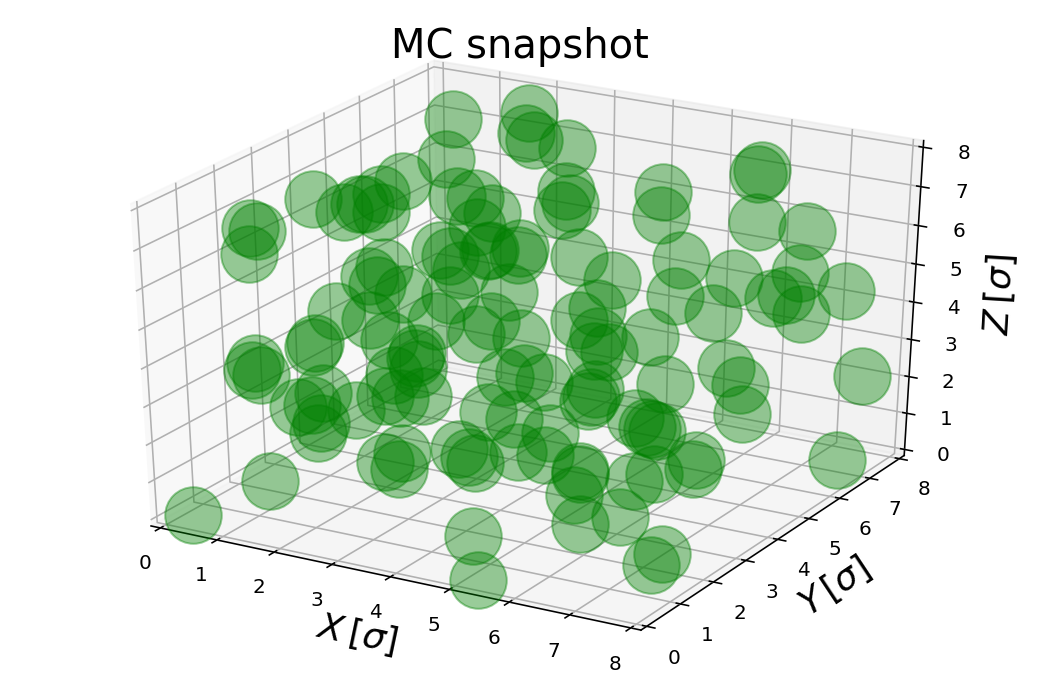

In [73]:
viz_p(particles,L)

In [74]:
particles[1]

array([1.50848837, 0.4987117 , 7.63418671])

### MC engine for LJ fluid in 3D (NVT ensemble)
Now that the main helper functions are set up we can put together a main Monte Carlo engine that loops through randomly selected particles and attemps their displacement via Metropolis Criterion. 

In [75]:
def doMC_LJ(particles,N,T,L,steps):
    '''Main MC engine'''
    
    # Initialize energies
    energy = 0 #getEnergy(particles,L) 
    
    # Loop through MC steps 
    for step in range(0, steps):
        
        # Randomly choose some particle i in  
        i=randint(0,N)
    
        #Record energy and location of particle i
        pi = particles[i]
        prev_E = getEnergy_p1(i,pi, particles,L)
    
        # Give a particle i a random push:
        pi[0] += uniform(-1, 1)
        pi[1] += uniform(-1, 1)
        pi[2] += uniform(-1, 1)
    
        # Apply PBC to fit particle i inside box
        pi = set_pbc(pi,L)
    
        # Evaluate energy diff
        new_E = getEnergy_p1(i,pi, particles,L)
        deltaE = new_E - prev_E

        # Metropolis acceptance/rejection conditions
        if deltaE < 0:
            energy += deltaE
            particles[i]=pi
    
        elif np.exp(-deltaE/T) > random():
            energy += deltaE
            particles[i]=pi
            
    return particles # Energy, trajecotry etc

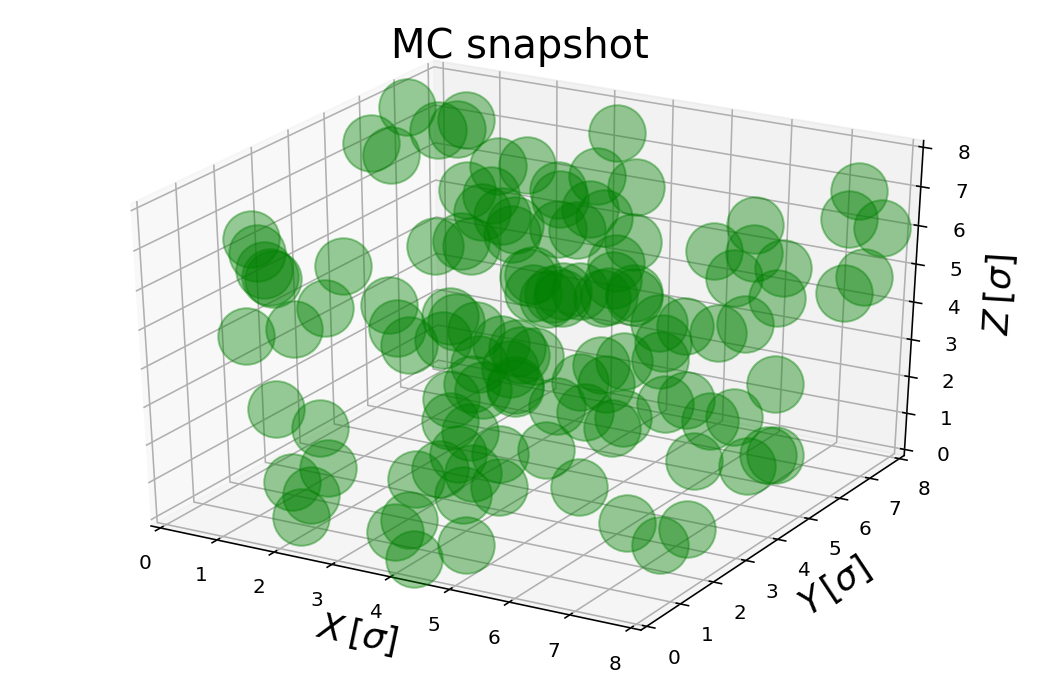

In [76]:
particles=generateBox(N,L)
particles=doMC_LJ(particles,N,T,L,5000)
viz_p(particles,L)

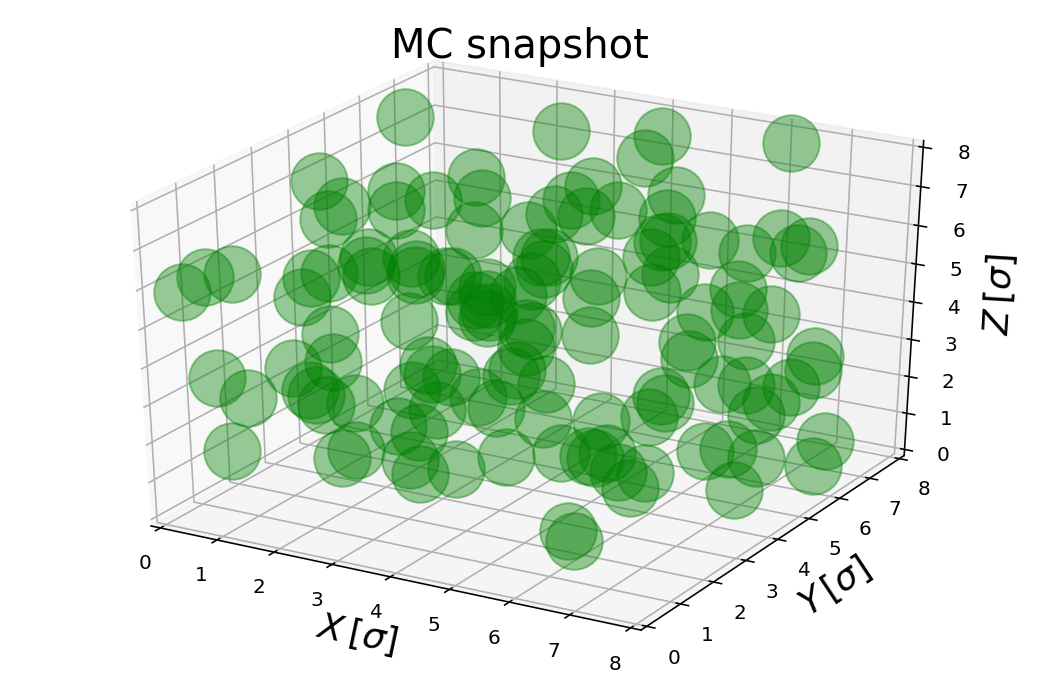

In [77]:
particles=generateBox(N,L)
particles=doMC_LJ(particles,N,T,L,5000)
viz_p(particles,L)

### Computing radial distribution function $g(r)$

In [78]:
@jit
def comp_g_r(particles,L):
    '''Computing radial distirbution function for a single configuration'''
    
    # Number of particles and density
    N=len(particles)
    rho=N/(L**3)

    # Prepare bins for histogramming
    nbins=60
    Lmin=0.0
    Lmax=L/2  
    dr=(Lmax-Lmin)/nbins
    
    r_distances=[]  
    
    for i in range(0,N-1):
        for j in range(i+1,N):
            
            pi,pj=particles[i],particles[j]

            dist=math.sqrt(get_distancesq(pi,pj,L))
            r_distances.append(dist)
            
    #Histogram distances 
    histRadii, edges = np.histogram(r_distances,bins=nbins,range=(Lmin,Lmax))
    radii = 0.5 *(edges[1:] + edges[:-1])  # radii of histograms R1,R2,..Lmax 
    
    # often folks loop over N*N pairs then divide by N
    # we have N*N-1/2 pairs e.g must divide by (N-1)/2 to have hist for N particles
    histRadii = histRadii/(0.5*(N-1))    
    
    #Compute histogram that would be displayed by an ideal gas of N particles 
    vol = (4.0/3.0) * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
    histIdeal=rho*vol 
    
    gr = histRadii/histIdeal 
    
    return radii,gr

In [79]:
# Simulation for computing g_r
N    = 126
L    = 8
T    = 0.85 
steps= 10000

######
particles=generateBox(N,L)
particles=doMC_LJ(particles,N,T,L,steps)
######

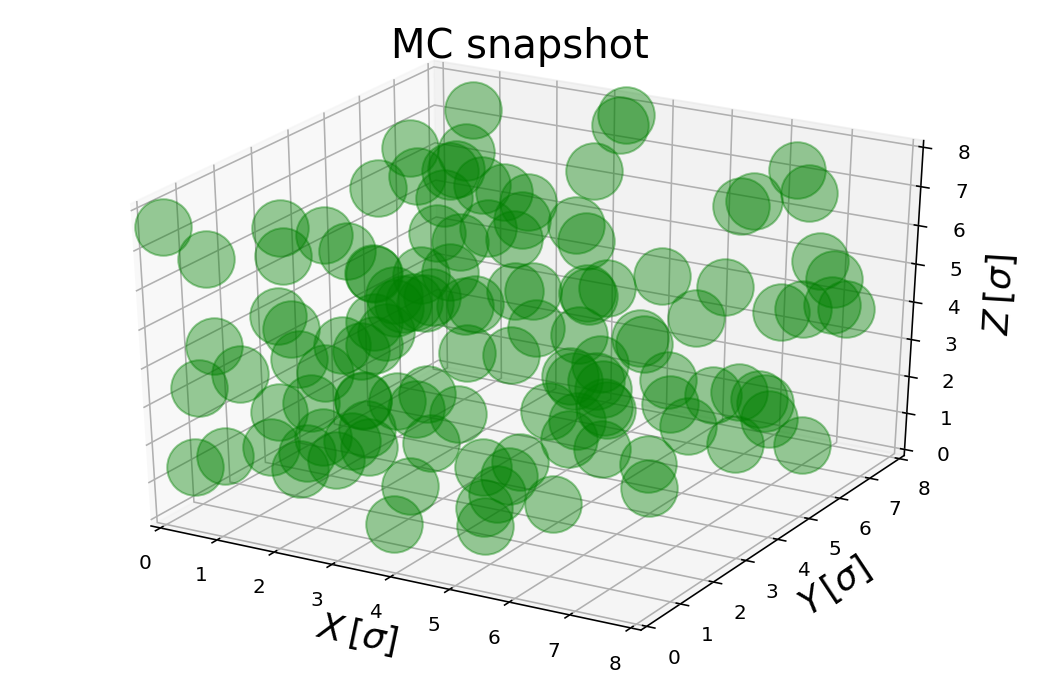

In [80]:
viz_p(particles,L)

#### A. Single snapshot result

In [81]:
radii,gr=comp_g_r(particles,L)

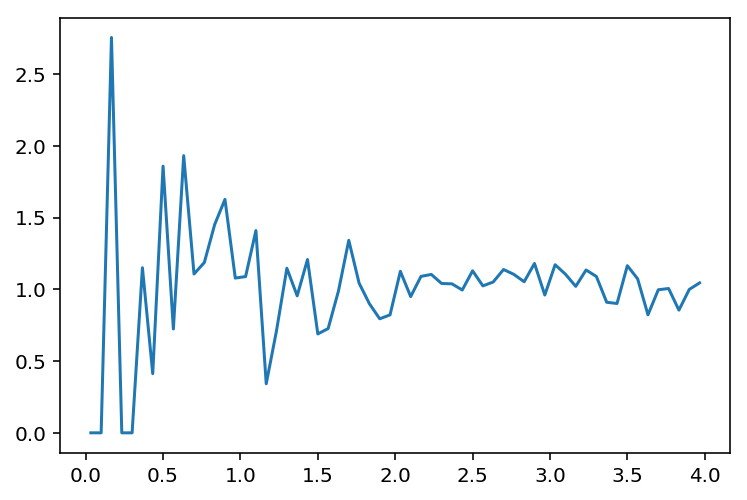

In [82]:
plt.plot(radii,gr)

#### B. Averaging over multiple snapshots

In [83]:
Gr=0
r=0
freq=100

for i in range(freq):
    
    particles=doMC_LJ(particles,N,T,L,10000)
    r,gr=comp_g_r(particles,L)
    Gr+=gr
    
Gr=Gr/freq

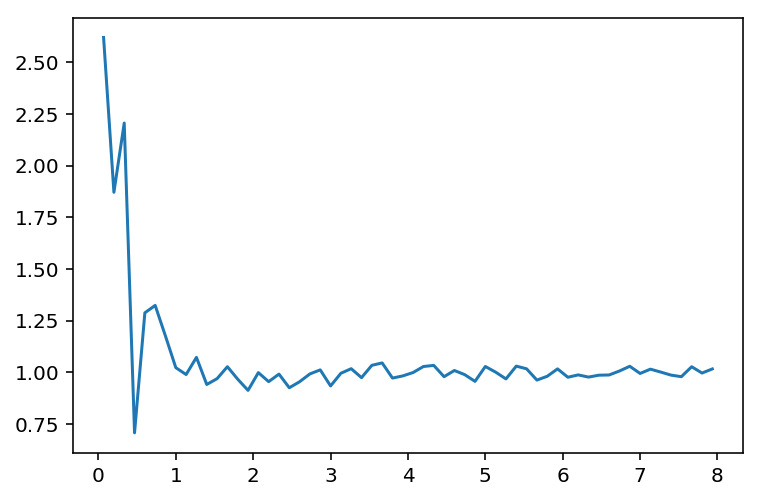

In [55]:
plt.plot(r,Gr)

In [500]:
ee=[]

freq=10000
for i in range(freq):
    doMC_LJ(particles,N,T,L,1)
    E=getEnergy(particles,L)
    ee.append(E)

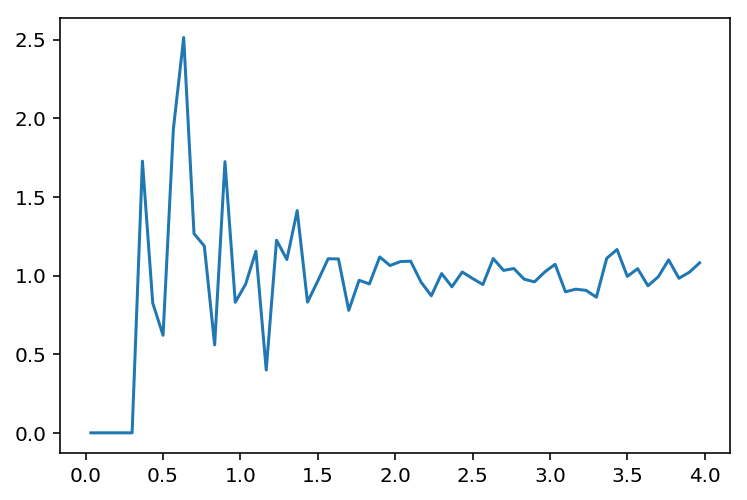

In [68]:
particles=doMC_LJ(particles,N,T,L,100000)
r,gr=comp_g_r(particles,L)
plt.plot(radii,gr)

In [39]:
'''Run this cell to render our markdown text with beautiful styles.'''
from IPython.core.display import HTML
def set_css_style(css_file_path):
    styles = open(css_file_path, "r").read()
    return HTML(styles)
set_css_style('./common/custom.css')